In [1]:
import pandas as pd

#Abre os bancos de dados necessários
pop = pd.read_csv('base_csv/pop2020.csv')
io = pd.read_csv('base_csv/caso_full.csv')

In [2]:
#Arruma os nomes das colunas para realizar o merge
pop.rename(columns={'Total':'total_inhabitants','Armenor':'ibge_code'}, inplace = True)

In [3]:
#Filtra somente os dados do último dia das semanas epidemiológicas
dates = ['2020-02-29', '2020-03-07', '2020-03-14', '2020-03-21',
               '2020-03-28', '2020-04-04', '2020-04-11', '2020-04-18',
               '2020-04-25', '2020-05-02', '2020-05-09', '2020-05-16',
               '2020-05-23', '2020-05-30', '2020-06-06', '2020-06-13',
               '2020-06-20', '2020-06-27', '2020-07-04', '2020-07-11',
               '2020-07-18', '2020-07-25', '2020-08-01']

datesDF = pd.DataFrame(dates,columns=['date'])

select_for_dates = pd.merge(io,datesDF, how = 'inner')

#Arruma o nome das colunas
select_for_dates.rename(columns={'city_ibge_code':'ibge_code','date':'week_last_day'}, inplace = True)


In [4]:
#Classifica os estados por macro regiões
def region(x):
    regions = {
        'norte':['AM','RR','AP','PA','TO','RO','AC'],
        'nordeste':['MA','PI','CE','RN','PE','PB','SE','AL','BA'],
        'centro-oeste':['MT','MS','GO','DF'],
        'sudeste':['MG','SP','RJ','ES'],
        'sul':['PR','RS','SC']       
    }
    for k,v in regions.items():
        if x['state'] in v:
            return k
    
select_for_dates['region'] = select_for_dates.apply(region,axis=1)

In [5]:
#Cria uma coluna com a sigla de cada estado.
states_list = {'ACRE':'AC','ALAGOAS':'AL','AMAPÁ':'AP','AMAZONAS':'AM',
               'BAHIA':'BA','CEARÁ':'CE','ESPÍRITO SANTO':'ES','GOIÁS':'GO',
               'MARANHÃO':'MA','MATO GROSSO':'MT','MATO GROSSO DO SUL':'MS',
               'MINAS GERAIS':'MG','PARÁ':'PA','PARAÍBA':'PB','PARANÁ':'PR',
               'PERNAMBUCO':'PE','PIAUÍ':'PI','RIO DE JANEIRO':'RJ',
               'RIO GRANDE DO NORTE':'RN','RIO GRANDE DO SUL':'RS','RONDÔNIA':'RO',
               'RORAIMA':'RR','SANTA CATARINA':'SC','SÃO PAULO':'SP','SERGIPE':'SE',
               'TOCANTINS':'TO','DISTRITO FEDERAL':'DF'}
pop['state']=pop['ARmaior'].apply(lambda x: states_list[x])

In [6]:
#Seleciona o df de população para cálculo por cidades
pop_cities = pop[['ibge_code','total_inhabitants']].copy()

In [7]:
#Seleciona do df de população para cálculo por estados
pop_states = pop[['state','total_inhabitants']].copy()
pop_states = pop_states.groupby(pop_states['state']).sum().reset_index()

In [8]:
#Coloca o total da população das cidades no df selecionado por datas
cities_df = pd.merge(select_for_dates,pop_cities, how ='inner')


In [9]:
#Coloca o total da população dos estados no df selecionado por datas
states_df = pd.merge(select_for_dates,pop_states, how ='inner')

In [10]:
#Seleciona apenas os estados
states_df = states_df[states_df['place_type']=='state']

In [11]:
#Encontrar o valor dos novos casoso por semana, para cidades e estados
last_city = 0
last_num = 0 

def get_num(x):
    global last_num, last_city
    if last_city == x['ibge_code']:
        current = x['last_available_confirmed']-last_num
        last_num = x['last_available_confirmed']
        return current
    else:
        last_city = x['ibge_code']
        last_num = 0
        return get_num(x)


cities_df = cities_df.sort_values(by=['ibge_code','week_last_day']).copy()
cities_df['new_week_cases'] = cities_df.apply(get_num , axis=1)

states_df = states_df.sort_values(by=['ibge_code','week_last_day']).copy()
states_df['new_week_cases'] = states_df.apply(get_num , axis=1)



In [12]:
#Encontrar o valor dos novos óbitos por semana

last_city = 0
last_num = 0 

def get_num(x):
    global last_num, last_city
    if last_city == x['ibge_code']:
        current = x['last_available_deaths']-last_num
        last_num = x['last_available_deaths']
        return current
    else:
        last_city = x['ibge_code']
        last_num = 0
        return get_num(x)



cities_df['new_week_deaths'] = cities_df.apply(get_num , axis=1)
states_df['new_week_deaths'] = states_df.apply(get_num , axis=1)


In [13]:
#DF por cidades
cities_df= cities_df.copy().reset_index()
cities_df = cities_df[['region','state','city','ibge_code','week_last_day','epidemiological_week','total_inhabitants','last_available_confirmed','last_available_deaths','new_week_cases','new_week_deaths']].copy()


In [14]:
#DF por estado

states_df = states_df[['state','week_last_day','epidemiological_week','total_inhabitants','last_available_confirmed','last_available_deaths','new_week_cases','new_week_deaths']].copy()


In [15]:
#DF por macro região 
region_df = cities_df.groupby(['region','epidemiological_week','week_last_day']).sum().reset_index()
region_df = region_df[['region','week_last_day','epidemiological_week','total_inhabitants','last_available_confirmed','last_available_deaths','new_week_cases','new_week_deaths']].copy()

In [16]:
#DF Brasil
brazil_df = states_df.groupby(['epidemiological_week','week_last_day']).sum().reset_index()
brazil_df = brazil_df[['week_last_day','epidemiological_week','total_inhabitants','last_available_confirmed','last_available_deaths','new_week_cases','new_week_deaths']].copy()

In [17]:
#---------------------Indicadores -----------------brazil_df----

In [18]:
#Indicador de Casos e Óbitos acumulados,por semana epidemiológica, já esta no DF, 
#respesctivamente nas colunas last_available_confirmed e last_available_deaths

In [19]:
#Novos Casos e Novos Óbitos, por semana epidemiológica, já está no DF,
#respesctivamente nas colunas new_week_cases e new_week_deaths

In [20]:
def indicators(data_frame):
    #Prevalência
    data_frame['prevalence'] = data_frame.apply(lambda x:x['last_available_confirmed']*100000/x['total_inhabitants'] , axis=1)
    
    #Indicador Mortalidade
    data_frame['mortality'] = data_frame.apply(lambda x:x['last_available_deaths']*100000/x['total_inhabitants'] , axis=1)
    
    #Indicador de Letalidade
    def lethality(x):
        if x['last_available_confirmed']==0:
            return 0
        else:
            return x['last_available_deaths']/x['last_available_confirmed']
    data_frame['lethality'] = data_frame.apply(lethality, axis=1)
    
    #Incidência de novos casos
    data_frame['incidence_cases'] = data_frame.apply(lambda x:x['new_week_cases']*100000/x['total_inhabitants'] , axis=1)
    
    #Incidência de novos óbitos
    data_frame['incidence_deaths'] = data_frame.apply(lambda x:x['new_week_deaths']*100000/x['total_inhabitants'] , axis=1)

    #Indicador Fator de Crescimento  dos casos
    last_number_cases=0

    def get_FC_cases(x):
        nonlocal last_number_cases
        if last_number_cases ==0:
            last_number_cases = x['new_week_cases']
            return 0
        else:
            fc= x['new_week_cases']/last_num
            last_number_cases = x['new_week_cases']
            return fc

    data_frame['cases_growth_factor'] = data_frame.apply(get_FC_cases, axis=1)

    #Indicador Fator de Crescimento  dos óbitos
    last_number_deaths=0

    def get_FC_deaths(x):
        nonlocal last_number_deaths
        if last_number_deaths ==0:
            last_number_deaths = x['new_week_deaths']
            return 0
        else:
            fc= x['new_week_deaths']/last_num
            last_number = x['new_week_deaths']
            return fc

    data_frame['deaths_growth_factor'] = data_frame.apply(get_FC_deaths, axis=1)

In [21]:
#Lista com os DF criados
created_df = [cities_df,states_df,region_df,brazil_df]

In [22]:
#Cálcula os indicadores para todos os DF
for df in created_df:
    indicators(df)

## Guardando dados no banco de dados local 

In [23]:
#Remove o BD caso ele já exista
import os
os.remove ("resultados/indicadores.db") if os.path.exists ("resultados/indicadores.db") else None

In [24]:
#Importa a biblioteca do sqlite, cria a conexão e o ponteiro
import sqlite3
con = sqlite3.connect("resultados/indicadores.db")  ##OBS: se o BD não existir, ele é criado automaticamente
cur = con.cursor()

In [25]:
#Guarda os dataframes no BD (se a taela já existir, substitui)
cities_df.to_sql('cities_df', con, if_exists='replace', index=False)
states_df.to_sql('states_df', con, if_exists='replace', index=False)
region_df.to_sql('region_df', con, if_exists='replace', index=False)
brazil_df.to_sql('brazil_df', con, if_exists='replace', index=False)

## Leitura e consulta do BD
- OBS: A partir daqui o código já pode ser incorporado ao notebook de visualização, já que os dados já estão salvos no BD. Se esse for o caso, tire do comentário a próxima célula.

In [ ]:
#Importa a biblioteca do sqlite, cria a conexão e o ponteiro
#import sqlite3
#con = sqlite3.connect("resultados/indicadores.db")  ##OBS: se o BD não existir, ele é criado automaticamente
#cur = con.cursor()

#### plotar gráficos a partir de Dataframes (mais fácil)

In [ ]:
##Lendo tabelas do BD direto para DataFrames (pode ser usado para gerar gráficos a partir dos DFs)
cities_df = pd.read_sql('select * from cities_df', con)
states_df = pd.read_sql('select * from states_df', con)
region_df = pd.read_sql('select * from region_df', con)
brazil_df = pd.read_sql('select * from brazil_df', con)

##PLOTAR AQUI

#### plotar gráficos diretamente do BD (mais rápido)

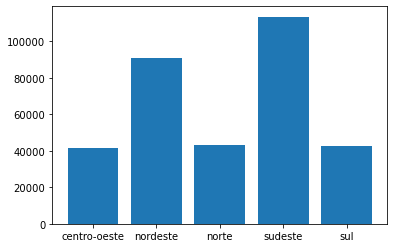

In [26]:
#exemplo de plotagem
import matplotlib.pyplot as plt

##MODELO: "SELECT colunas FROM tabela"

cur.execute("SELECT region, epidemiological_week, new_week_cases FROM region_df")

regioes = []
semana_ep = []      #<----não está sendo usado no exemplo
novos_casos = []

dados = cur.fetchall() 
for linha in dados:
    regioes.append(linha[0])
    semana_ep.append(linha[1])     #<----não está sendo usado no exemplo
    novos_casos.append(linha[2])
    
plt.bar(regioes, novos_casos)
plt.show()

### CONSULTAS - modo visual (recomendado)
- Para conseguir visualizar diretamente o banco de dados (sem o python), entre em 'https://sqlitebrowser.org/dl/' e baixe o SqLite Browser. Nele é possível fazer consultas e conferência de dados. (essa aplicação é leve e confiável)
- Com o programa instalado, basta abrir o arquivo "indicadores.db" e depoir ir em "tabelas". Depois clique com o botão direito em uma delas e selecione a opção "navegar tabelas". Lá é possivel visualizar e filtar dados diretamente.

### CONSULTAS - por código
- Também é possível fazer solicitações específicas para o banco de dados diretamente por meio de instruções SQL. Abaixo há um exemplo que soma o total de habitantes da tabela de cidades para as cidades da região sudeste.

In [27]:
##Consultar soma de valores
##ALTERE esses valores para personalizar sua consulta

col = 'total_inhabitants'  ##Coluna que você quer somar
tabela = 'cities_df'       ##De qual tabela ela é
col_condicao = 'region'    ##Filtrar por alguma outra coluna 
condicao = 'sudeste'       ##Condição para filtrar

#executa instrução
pd.read_sql("select sum({}) from {} where {} = '{}' ".format(col, tabela, col_condicao, condicao), con )

,sum(total_inhabitants)
0,1.627281e+09
